### importing the library

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10,6
from datetime import datetime
import warnings
warnings.simplefilter('ignore')

### importing the data

In [2]:
df = pd.read_csv('USCarrier_Traffic.csv')

In [3]:
df.head()

,Period,Total
0,Jan-00,49045412
1,Feb-00,49306303
2,Mar-00,60443541
3,Apr-00,58286680
4,May-00,60533783


### Dropping the null values

In [4]:
df.dropna(inplace = True)

### changing the date format 

In [5]:
df['Period'] = df['Period'].str.replace('-' , ' 20')

In [6]:
df['Period'] = df['Period'].str.strip()

In [7]:
for each in range(len(df['Period'])):
    df['Period'][each] = datetime.strptime(df['Period'][each], '%b %Y').strftime('%Y-%m-%d')

In [8]:
df.set_index('Period' , inplace=True)
df.head()

,Total
Period,
2000-01-01,49045412
2000-02-01,49306303
2000-03-01,60443541
2000-04-01,58286680
2000-05-01,60533783


### Plotting the data

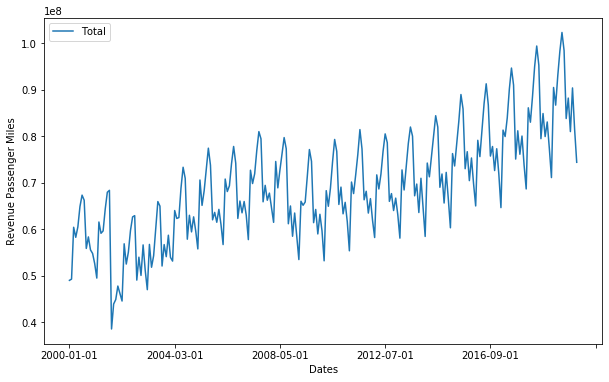

In [9]:
#plt.plot(df)
df.plot()
plt.xlabel('Dates')
plt.ylabel(' Revenue Passenger Miles ')
plt.show()

### QQ Plot

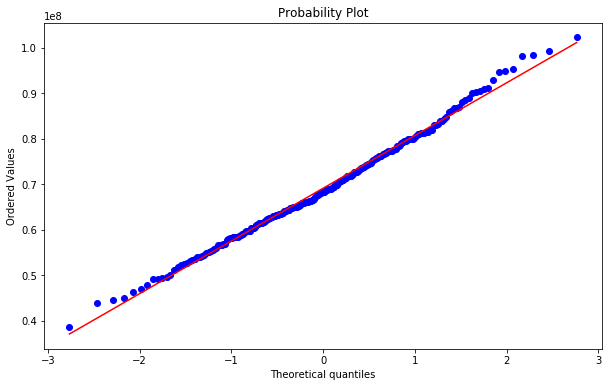

In [10]:
import pylab 
import scipy.stats

scipy.stats.probplot(df['Total'] , plot=pylab)
plt.show()

### Setting the desired frequency 

In [11]:
df = df.asfreq('MS') # MS is for month start ....

### Checking for null value after converting to desired frequncy

In [12]:
df.isnull().sum()

Total    0
dtype: int64

### Splitting the Data

In [13]:
# To to a 80 - 20 split 
size = int(len(df)*0.8)  # sets the size or index of 80% of the data
size

193

In [14]:
df_train = df.iloc[:size]
df_test = df.iloc[size:]

In [15]:
df_train.shape , df_test.shape

((193, 1), (49, 1))

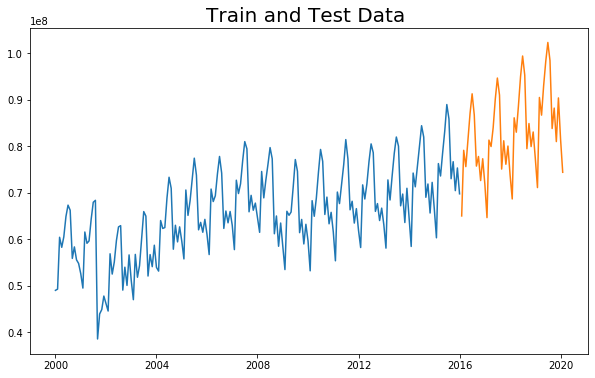

In [16]:
plt.plot(df_train)
plt.plot(df_test)
plt.title('Train and Test Data ' , size = 20 )
plt.show()

### Stationarity

In [17]:
import statsmodels.tsa.stattools as sts
Dickey_fuller = sts.adfuller(df_train['Total'])

Test_Statistic = Dickey_fuller[0]
p_value  = Dickey_fuller[1]
Lags_used = Dickey_fuller[2]
Number_of_observations = Dickey_fuller[3]
Critical_Value_1 = Dickey_fuller[4]['1%']
Critical_Value_5  = Dickey_fuller[4]['5%']
Critical_Value_10 = Dickey_fuller[4]['10%']

Dickey_fuller_table = pd.DataFrame([Test_Statistic   , p_value   , Lags_used   , Number_of_observations   , Critical_Value_1     ,  Critical_Value_5     ,  Critical_Value_10] , 
                                   index =      ['Test Statistic' , 'P value' , 'Lags used' , 'Number of observations' , 'Critical Value 1 %' ,  'Critical Value 5 %' ,  'Critical Value 10 % '] , 
                                   columns = ['values']
                                  )

Dickey_fuller_table

,values
Test Statistic,-0.773021
P value,0.826919
Lags used,13.000000
Number of observations,179.000000
Critical Value 1 %,-3.467420
Critical Value 5 %,-2.877826
Critical Value 10 %,-2.575452


As the t stats  value is greater than that of critical value so we reject the null hypothesis that the data comes from stationary process that is its a non stationary data

### Applying log transformation 

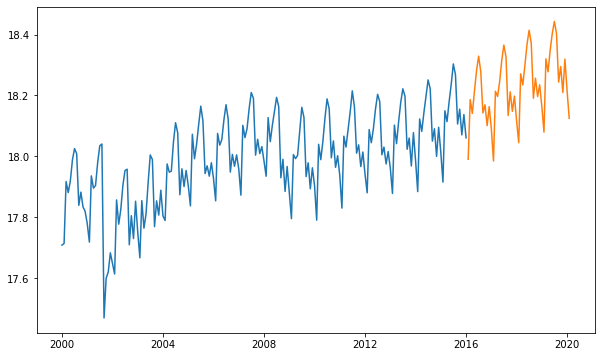

In [18]:
df_train=np.log(df_train)
df_test= np.log(df_test)
plt.plot(df_train)
plt.plot(df_test)
plt.show()

### Seasonality

In [19]:
from statsmodels.tsa.seasonal  import seasonal_decompose

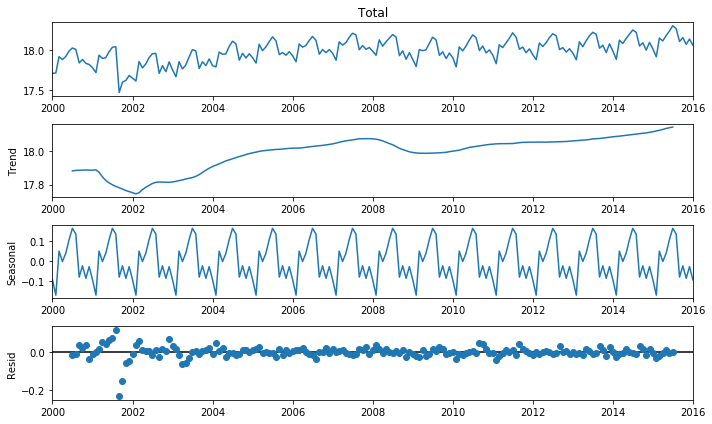

In [20]:
S_decomp_add = seasonal_decompose(df_train['Total'] , model='additive')
S_decomp_add.plot()
plt.show()

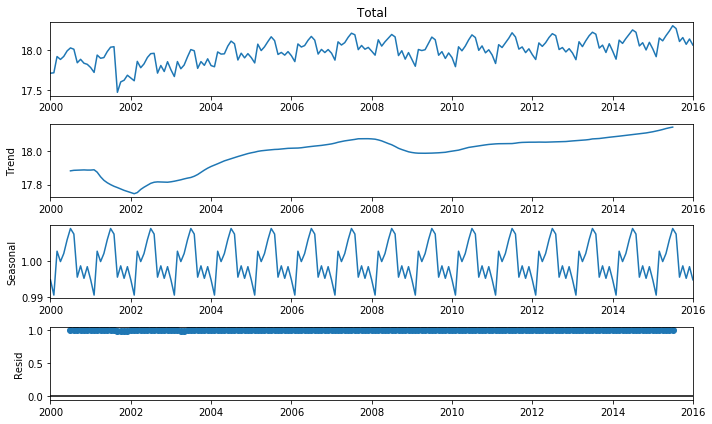

In [21]:
S_decomp_add = seasonal_decompose(df_train['Total'], model='multiplicative')
S_decomp_add.plot()
plt.show()

- As you clearly see there is seasonality in the model we would go with seasonal model like SARMA and SARIMAX

### Training the model using SARIMAX

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
model_sarimax = SARIMAX(df_train.Total , order=(1,1,1) , seasonal_order=(2,0,1,12))
result_sarimax = model_sarimax.fit()
result_sarimax.summary()

C:\Users\Sanket Takle\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Total   No. Observations:                  193
Model:             SARIMAX(1, 1, 1)x(2, 0, 1, 12)   Log Likelihood                 348.401
Date:                            Wed, 10 Jun 2020   AIC                           -684.801
Time:                                    17:18:39   BIC                           -665.257
Sample:                                01-01-2000   HQIC                          -676.886
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4309      0.201      2.143      0.032       0.037       0.825
ma.L1         -0.7110      0.135     -5.267      0.000      -0.976      -0.446
ar.S.L12       0.8502      0.051     16.541      0.000       0.750       0.951
ar.S.L24       0.1428      0.049      2.926      0.003       0.047       0.238
ma.S.L12      -0.6649      0.076     -8.793      0.000      -0.813      -0.517
sigma2         0.0013   7.81e-05     16.719      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       40.54   Jarque-Bera (JB):              9681.60
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -3.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Inspecting the model  by checking residuals

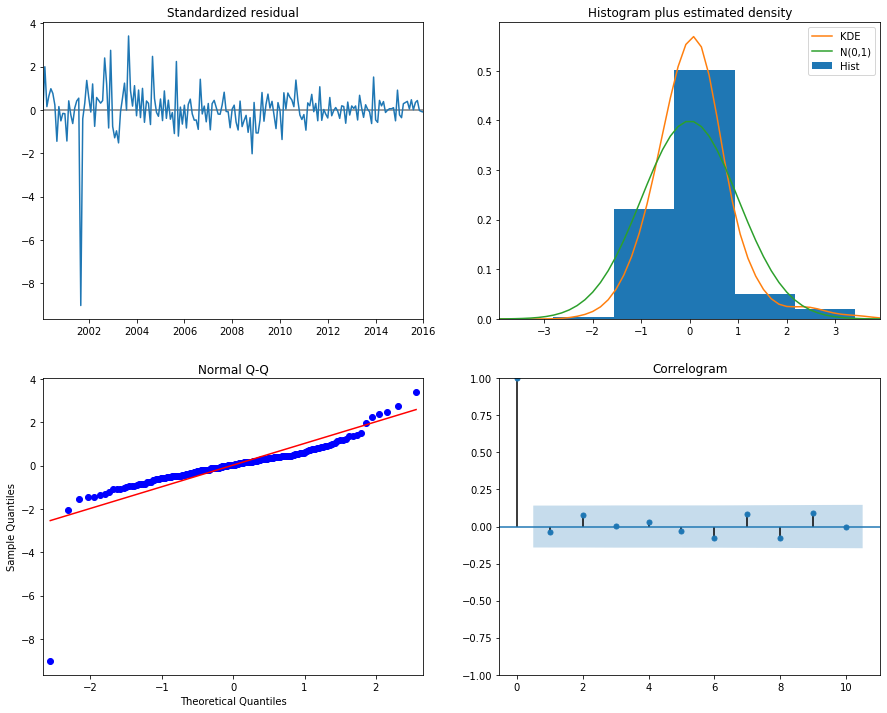

In [24]:
result_sarimax.plot_diagnostics(figsize=(15, 12))
plt.show()

### Testing the model 

In [25]:
# period for predicting / forecasting 
start_date = '2016-02-01'
end_date = '2020-02-01'

In [26]:
sarimax_pred = result_sarimax.predict(start = start_date , end = end_date)

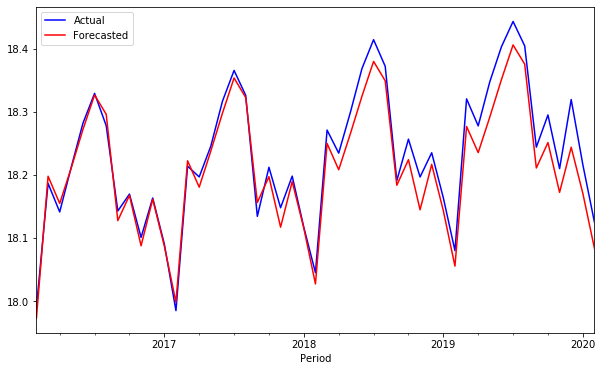

In [27]:
df_test.plot(color = 'blue')
sarimax_pred.plot(color = 'red')
plt.legend(['Actual' , 'Forecasted'])
plt.show()

### Mean Squared Error

In [28]:
y_forecasted = sarimax_pred.mean()
y_truth = df_test

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 3)))

The Mean Squared Error of our forecasts is Total    0.012
dtype: float64


- The MSE of our forecast has a value of 0.012, which is very low as it is close to 0. 
- An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

### Forecasting 

In [29]:
# Get forecast 100 months ahead in future , this overlaps with our testing dates 
pred_uc = result_sarimax.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

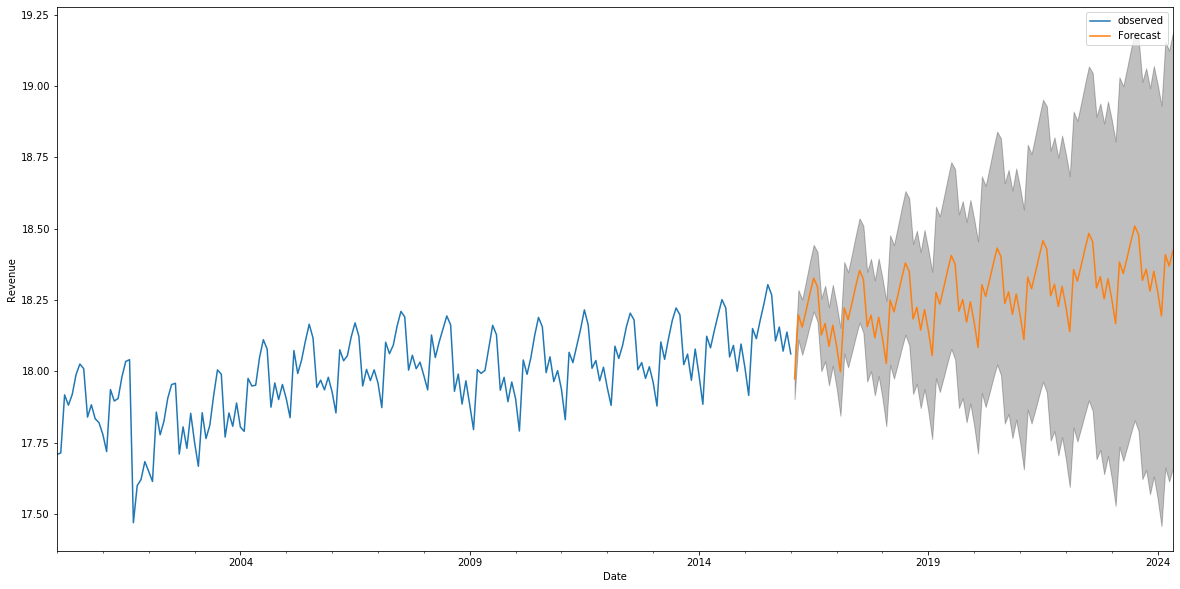

In [32]:
ax = df_train['Total'].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
plt.legend()
plt.show()

### How the data changes from month to month and year to year? 
- Any trend? 
- How fluctuated the curve is? 
- Any seasonal effects? 
- Any unusual years/months which have significantly small or large number? 
 

- Yes there is definately a Trend 
- Yes there is a seasonal effect 
- Yes there is a deep dive in years between 2002 and 2003